<a href="https://colab.research.google.com/github/UkeshThapa/Snowmelt-Driven-Streamflow-Prediction/blob/main/snowmelt_prediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U keras-tuner
!pip install keras==2.12.0
!pip install hydroeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# normalize the data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# model library

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

# hyperparameter tuner
import keras_tuner as kt
import time
# model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError


# loss

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [4]:
""
# Load your dataset

def load_dataset(path):
    return pd.read_csv(path)


file_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/bigdata.csv"
df_snow_melting = load_dataset(file_path)


df_snow_melting


,Date,Q,SCA,T,P,Day,Relative Humidity,Wind speed,Wind direction,Snow depth
0,1/1/2001,2.69,345.815123,-4.169740,0.000000,1,60.49,3.18,220.08,0.000170
1,1/2/2001,2.53,343.608727,-4.142604,0.000000,2,53.93,1.86,210.97,0.000133
2,1/3/2001,2.53,341.437417,-5.148725,0.000000,3,42.20,1.49,239.45,0.000128
3,1/4/2001,2.43,339.336277,-6.523695,0.031144,4,40.48,1.91,249.20,0.000122
4,1/5/2001,2.53,337.340394,-6.860106,0.000000,5,27.34,2.14,334.61,0.000116
...,...,...,...,...,...,...,...,...,...,...
4012,12/26/2012,2.91,228.615063,-5.651230,0.000000,361,46.49,1.43,257.42,0.000466
4013,12/27/2012,2.91,219.264614,-5.501225,0.000000,362,43.99,2.98,246.87,0.000437
4014,12/28/2012,3.03,210.043412,-5.526874,0.000000,363,27.19,2.54,263.59,0.000410
4015,12/29/2012,2.97,201.080703,-5.107484,0.000000,364,33.50,3.10,256.97,0.000379


In [5]:
features = ['Date',"Q","SCA","T",'P']
# features = ["Q"]
df_snow_melting = df_snow_melting[features]

In [6]:
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month,day,year = int(split[0]),int(split[1]),int(split[2])

    return datetime.datetime(year=year,month=month,day=day)


In [7]:
df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)

df_snow_melting

<ipython-input-7-164b30e8e586>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)


,Date,Q,SCA,T,P
0,2001-01-01,2.69,345.815123,-4.169740,0.000000
1,2001-01-02,2.53,343.608727,-4.142604,0.000000
2,2001-01-03,2.53,341.437417,-5.148725,0.000000
3,2001-01-04,2.43,339.336277,-6.523695,0.031144
4,2001-01-05,2.53,337.340394,-6.860106,0.000000
...,...,...,...,...,...
4012,2012-12-26,2.91,228.615063,-5.651230,0.000000
4013,2012-12-27,2.91,219.264614,-5.501225,0.000000
4014,2012-12-28,3.03,210.043412,-5.526874,0.000000
4015,2012-12-29,2.97,201.080703,-5.107484,0.000000


In [9]:
# Visualization

# from scipy import stats

# df_snow_melting['Month'] = df_snow_melting['Date'].dt.month
# month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
#                7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
# df_snow_melting['Month'] = df_snow_melting['Month'].map(month_names)
# df_snow_melting['SCA_percentage'] = (df_snow_melting['SCA'] / df_snow_melting['SCA'].max()) * 100

# # Visualize the data without displaying outliers in the box plot
# plt.figure(figsize=(15, 15))
# sns.boxplot(x='Month', y='SCA_percentage', data=df_snow_melting, showfliers=False)
# # plt.title('Box Plot of SCA Percentage Across Months (Without Displaying Outliers)')
# plt.xlabel('Months')
# plt.ylim(20)
# plt.ylabel('SCA (%)')
# plt.show()

In [10]:
import pandas as pd
import numpy as np

# data scaled

df_input = df_snow_melting[['Q','SCA', 'T']]


def min_max_scaling(data):
    # Subtract the minimum value and divide by the range
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)

    return scaled_data, min_val, max_val

# Assuming df_snow_melting is your DataFrame
columns_to_scale = ['Q', 'SCA', 'T']
scaled_df = df_input.copy()

# Apply min-max scaling to specified columns
for column in columns_to_scale:
    scaled_df[column], _, _ = min_max_scaling(df_input[column])

# Print the scaled DataFrame
print(scaled_df)


             Q       SCA         T
0     0.087577  0.851791  0.302737
1     0.080424  0.844592  0.304062
2     0.080424  0.837508  0.254949
3     0.075953  0.830653  0.187831
4     0.080424  0.824141  0.171409
...        ...       ...       ...
4012  0.097412  0.469406  0.230419
4013  0.097412  0.438898  0.237742
4014  0.102776  0.408812  0.236490
4015  0.100094  0.379570  0.256962
4016  0.097412  0.351593  0.261586

[4017 rows x 3 columns]


In [11]:
# Assuming scaled_df is the DataFrame with min-max scaled values
original_df = scaled_df.copy()

# Dictionary to store min and max values for each column
min_max_dict = {}


# originate it to the normal
for column in columns_to_scale:
    # Retrieve min and max values from the original scaling
    min_val = np.min(df_snow_melting[column])
    max_val = np.max(df_snow_melting[column])

    # Store min and max values in the dictionary
    min_max_dict[column] = {'min': min_val, 'max': max_val}

    # Invert the min-max scaling
    original_df[column] = scaled_df[column] * (max_val - min_val) + min_val

# Print the original DataFrame
print(original_df)


         Q         SCA         T
0     2.69  345.815123 -4.169740
1     2.53  343.608727 -4.142604
2     2.53  341.437417 -5.148725
3     2.43  339.336277 -6.523695
4     2.53  337.340394 -6.860106
...    ...         ...       ...
4012  2.91  228.615063 -5.651230
4013  2.91  219.264614 -5.501225
4014  3.03  210.043412 -5.526874
4015  2.97  201.080703 -5.107484
4016  2.91  192.505735 -5.012752

[4017 rows x 3 columns]


In [12]:
scaled_df

,Q,SCA,T
0,0.087577,0.851791,0.302737
1,0.080424,0.844592,0.304062
2,0.080424,0.837508,0.254949
3,0.075953,0.830653,0.187831
4,0.080424,0.824141,0.171409
...,...,...,...
4012,0.097412,0.469406,0.230419
4013,0.097412,0.438898,0.237742
4014,0.102776,0.408812,0.236490
4015,0.100094,0.379570,0.256962


In [34]:


# scaler = StandardScaler()

# # Select the features you want to scale
# features_to_scale = ['Q', 'SCA', 'T']

# # Fit the scaler to the data and transform the selected features
# df_input[features_to_scale] = scaler.fit_transform(df_input[features_to_scale])


<ipython-input-34-69a01f0b435c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[features_to_scale] = scaler.fit_transform(df_input[features_to_scale])


In [55]:
def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 2

X, y = df_to_X_y(scaled_df,WINDOW_SIZE)

X.shape, y.shape

((4015, 2, 3), (4015,))

In [14]:
X

array([[[0.08757656, 0.85179121, 0.3027373 ],
        [0.0804238 , 0.84459246, 0.3040619 ]],

       [[0.0804238 , 0.84459246, 0.3040619 ],
        [0.0804238 , 0.83750818, 0.25494888]],

       [[0.0804238 , 0.83750818, 0.25494888],
        [0.07595333, 0.83065285, 0.18783076]],

       ...,

       [[0.0974116 , 0.46940552, 0.23041949],
        [0.0974116 , 0.43889805, 0.23774186]],

       [[0.0974116 , 0.43889805, 0.23774186],
        [0.10277616, 0.40881226, 0.23648982]],

       [[0.10277616, 0.40881226, 0.23648982],
        [0.10009388, 0.37956986, 0.25696202]]])

In [15]:
import hydroeval as he

In [16]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Assuming you have X_train, y_train, X_test, y_test defined

# Define the LSTM model with hyperparameters
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop, SGD

def build_lstm_model(hp):
    model = Sequential()

    # Hyperparameters for LSTM
    lstm_layers = hp.Int('lstm_layers', min_value=1, max_value=3)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)

    for _ in range(lstm_layers):
        model.add(LSTM(units=lstm_units, activation='relu', return_sequences=True))
        model.add(Dropout(dropout_rate))

    model.add(LSTM(units=lstm_units, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='linear'))

    # Hyperparameters for optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'adamax', 'rmsprop', 'sgd'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'adamax':
        optimizer = Adamax(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model
# Assume you have your data X and y
best_model_hyperparameters = None
best_model_mae = float('inf')

worst_model_hyperparameters = None
worst_model_mae = float('-inf')

# Initialize K-Fold cross-validation for the outer loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)


# Perform Nested Cross-Validation
nested_scores = []

for fold_outer_idx, (train_ix, test_ix) in enumerate(outer_cv.split(X)):
    X_train_outer, X_test_outer = X[train_ix], X[test_ix]
    y_train_outer, y_test_outer = y[train_ix], y[test_ix]

    # Inner loop for hyperparameter tuning
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    for fold_idx, (train_ix_inner, val_ix) in enumerate(inner_cv.split(X_train_outer)):
        X_train_inner, X_val = X_train_outer[train_ix_inner], X_train_outer[val_ix]
        y_train_inner, y_val = y_train_outer[train_ix_inner], y_train_outer[val_ix]

        # Initialize Keras Tuner
        tuner = RandomSearch(
            build_lstm_model,
            objective='val_loss',
            max_trials=15,
            directory=f'/content/drive/MyDrive/research/lstm_parameter/keras_tuner_random_dir_fold_lstm__new_{fold_outer_idx}_{fold_idx}',
            project_name=f'/content/drive/MyDrive/research/lstm_parameter/keras_tuner_random_dir_fold_lstm__new_{fold_outer_idx}_{fold_idx}/hyperparameter_random_tuning_fold_lstm_{fold_outer_idx}_{fold_idx}'
        )

        # Search for the best hyperparameters
        tuner.search(X_train_inner, y_train_inner, validation_data=(X_val, y_val), epochs=30)

        best_hps = tuner.oracle.get_best_trials(1)[0].hyperparameters
        print(f"Best hyperparameters for fold {fold_idx}: {best_hps}")

        model = build_lstm_model(best_hps)
        es = EarlyStopping(patience=10, restore_best_weights=True)

        model.fit(
            X_train_inner,
            y_train_inner,
            validation_data=(X_val, y_val),
            epochs=100,
            batch_size=32,
            callbacks=[es]
        )

        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)

        # Update best model
        if mae < best_model_mae:
            best_model_mae = mae
            best_model_hyperparameters = best_hps
            best_model = model

        # Update worst model
        if mae > worst_model_mae:
            worst_model_mae = mae
            worst_model_hyperparameters = best_hps
            worst_model = model

    # Now that we have the best and worst models, evaluate them on the test set
    start_time = time.time()
    y_pred_best = best_model.predict(X_test_outer)
    y_pred_worst = worst_model.predict(X_test_outer)
    end_time = time.time()

    mse_best = mean_squared_error(y_test_outer, y_pred_best)
    mae_best = mean_absolute_error(y_test_outer, y_pred_best)
    rmse_best = np.sqrt(mse_best)

    nse_best = he.evaluator(he.nse, y_pred_best, y_test_outer)
    kge_best, r, alpha, beta = he.evaluator(he.kge, y_pred_best, y_test_outer)
    print("Best Model:")
    print("KGE : ", kge_best)

    r2_best = r2_score(y_test_outer, y_pred_best)
    time_duration = end_time - start_time

    mse_worst = mean_squared_error(y_test_outer, y_pred_worst)
    mae_worst = mean_absolute_error(y_test_outer, y_pred_worst)
    rmse_worst = np.sqrt(mse_worst)

    nse_worst = he.evaluator(he.nse, y_pred_worst, y_test_outer)
    kge_worst, r, alpha, beta = he.evaluator(he.kge, y_pred_worst, y_test_outer)
    print("Worst Model:")
    print("KGE : ", kge_worst)

    r2_worst = r2_score(y_test_outer, y_pred_worst)
    time_duration = end_time - start_time

    nested_scores.append({
        "Best Model": {
            "MSE": mse_best,
            "R^2": r2_best,
            "RMSE": rmse_best,
            "MAE": mae_best,
            "testing time": time_duration,
            "nse": nse_best,
            "kge": kge_best
        },
        "Worst Model": {
            "MSE": mse_worst,
            "R^2": r2_worst,
            "RMSE": rmse_worst,
            "MAE": mae_worst,
            "testing time": time_duration,
            "nse": nse_worst,
            "kge": kge_worst
        }
    })

# Save the best and worst hyperparameters
print("Best Hyperparameters:", best_model_hyperparameters)
print("Best MAE:", best_model_mae)

print("Worst Hyperparameters:", worst_model_hyperparameters)
print("Worst MAE:", worst_model_mae)


# Print or use the nested_scores as needed
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']}, kge: {scores['Best Model']['kge']}, nse: {scores['Best Model']['nse']}")


Trial 15 Complete [00h 01m 34s]
val_loss: 0.0008169392822310328

Best val_loss So Far: 0.0007240078411996365
Total elapsed time: 00h 11m 35s
Best hyperparameters for fold 2: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x78abcf54b3a0>
Epoch 1/100
67/67 [==============================] - 4s 16ms/step - loss: 0.0151 - mae: 0.0797 - val_loss: 0.0030 - val_mae: 0.0418
Epoch 2/100
67/67 [==============================] - 1s 9ms/step - loss: 0.0053 - mae: 0.0487 - val_loss: 0.0030 - val_mae: 0.0412
Epoch 3/100
67/67 [==============================] - 1s 9ms/step - loss: 0.0049 - mae: 0.0474 - val_loss: 0.0011 - val_mae: 0.0236
Epoch 4/100
67/67 [==============================] - 1s 9ms/step - loss: 0.0043 - mae: 0.0448 - val_loss: 0.0017 - val_mae: 0.0303
Epoch 5/100
67/67 [==============================] - 1s 9ms/step - loss: 0.0043 - mae: 0.0456 - val_loss: 0.0028 - val_mae: 0.0399
Epoch 6/100
67/67 [==============================] - 1s 9ms/step - loss:

In [27]:
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']}, kge: {scores['Best Model']['kge']}, nse: {scores['Best Model']['nse']}, time: {scores['Best Model']['testing time']}")


Nested Cross-Validation Scores:

Fold 1 - MSE: 0.0007382034416983829, R^2: 0.9875276034008267, RMSE: 0.02716989955260017, MAE: 0.014329538643715466, kge: [0.97689545], nse: [0.9875276], time: 0.6980786323547363

Fold 2 - MSE: 0.0005613232438028857, R^2: 0.990315325997024, RMSE: 0.023692261264026397, MAE: 0.013666515592591242, kge: [0.97575407], nse: [0.99031533], time: 0.4625706672668457

Fold 3 - MSE: 0.000536403845447057, R^2: 0.9905989388055814, RMSE: 0.023160393896630018, MAE: 0.01129992447677101, kge: [0.98123276], nse: [0.99059894], time: 0.9543359279632568

Fold 4 - MSE: 0.0005391250492679317, R^2: 0.9912590815913049, RMSE: 0.0232190665029396, MAE: 0.011615473795956257, kge: [0.98400383], nse: [0.99125908], time: 0.5683560371398926

Fold 5 - MSE: 0.0004276013901879799, R^2: 0.992712259620083, RMSE: 0.02067852485522069, MAE: 0.010689439375384965, kge: [0.98757804], nse: [0.99271226], time: 0.785973072052002


In [28]:

# # After the nested cross-validation, you can analyze and compare the results for different folds
# for fold, scores in enumerate(nested_scores):
#     print(f"Fold {fold + 1} - MSE: {scores['MSE']:.3f}, MAE: {scores['MAE']:.3f},RMSE: {scores['RMSE']:.3f}, R^2: {scores['R^2']:.3f}")

# Calculate overall statistics
all_mse = [scores['Best Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Best Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Best Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Best Model']['R^2'] for scores in nested_scores]
all_kge = [scores['Best Model']['kge'] for scores in nested_scores]
all_nse = [scores['Best Model']['nse'] for scores in nested_scores]
all_time = [scores['Best Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_kge = np.mean(all_kge)
mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean kge: {mean_kge:.3f}")
print(f"Mean nse: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")

Mean MSE: 0.001
Mean MAE: 0.012
Mean RMSE: 0.024
Mean R^2: 0.990
Mean kge: 0.981
Mean nse: 0.990
Mean time: 0.694


In [25]:
best_hyperparameters_dict = best_model_hyperparameters.values
worst_hyperparameters_dict = worst_model_hyperparameters.values

print("Best Hyperparameters:", best_hyperparameters_dict)
print("Worst Hyperparameters:", worst_hyperparameters_dict)


Best Hyperparameters: {'lstm_layers': 1, 'lstm_units': 128, 'dropout_rate': 0.2, 'optimizer': 'adam', 'learning_rate': 0.001208306909422661}
Worst Hyperparameters: {'lstm_layers': 1, 'lstm_units': 64, 'dropout_rate': 0.30000000000000004, 'optimizer': 'rmsprop', 'learning_rate': 0.0056885040151349285}


126/126 [==============================] - 1s 5ms/step


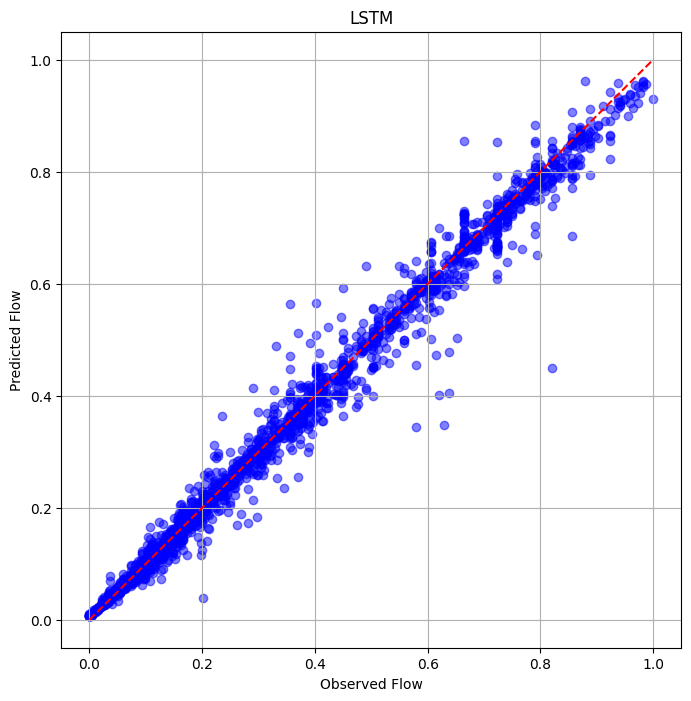

In [56]:
import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = loaded_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('LSTM')
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow')
plt.grid(True)
plt.show()


In [20]:
# Assuming best_model is your final trained model
best_model.save('/content/drive/MyDrive/research/lstm_parameter/best_model_lstm.h5')


In [52]:
from keras.models import load_model
import tensorflow as tf

# Load the saved model with custom_objects
loaded_model = load_model('/content/drive/MyDrive/research/lstm_parameter/best_model_lstm.h5')


In [53]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 2, 128)            67584     
                                                                 
 dropout_4 (Dropout)         (None, 2, 128)            0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 199,297
Trainable params: 199,297
Non-trainable params: 0
_________________________________________________________________


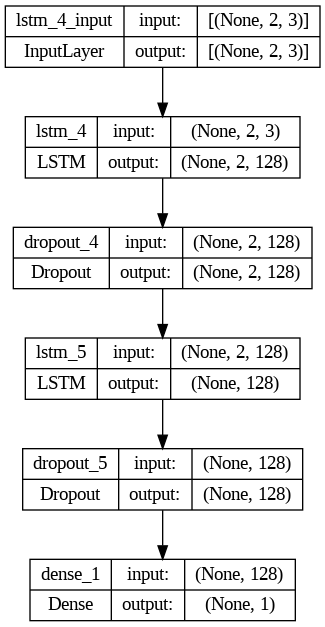

In [26]:
from keras.utils import plot_model
# Visualize the model architecture and save the diagram to a file
plot_model(loaded_model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

In [29]:
best_model_hyperparameters = best_model.get_config()

# Print the hyperparameters
print("Best Model Hyperparameters:")
print(best_model_hyperparameters)

Best Model Hyperparameters:
{'name': 'sequential_1', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 2, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'lstm_4_input'}}, {'class_name': 'LSTM', 'config': {'name': 'lstm_4', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 128, 'activation': 'relu', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'recurrent_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0,

In [30]:
# Assuming best_model is your trained model
optimizer = best_model.optimizer
learning_rate = float(optimizer.learning_rate.numpy())

# Print the optimizer and learning rate
print("Optimizer:", type(optimizer).__name__)
print("Learning Rate:", learning_rate)


Optimizer: Adam
Learning Rate: 0.0012083068722859025


In [31]:
# Assuming best_model is your trained model

# Function to extract dropout rate from a layer
def get_dropout_rate(layer):
    if hasattr(layer, 'rate'):
        return layer.rate
    elif hasattr(layer, 'dropout'):
        return layer.dropout
    else:
        return None

# Iterate through layers of the model and find the dropout rates
dropout_rates = []

for layer in best_model.layers:
    rate = get_dropout_rate(layer)
    if rate is not None:
        dropout_rates.append((layer.name, rate))

# Print the dropout rates
print("Dropout Rates:")
for layer_name, rate in dropout_rates:
    print(f"{layer_name}: {rate}")


Dropout Rates:
lstm_4: 0.0
dropout_4: 0.2
lstm_5: 0.0
dropout_5: 0.2


# SVR

In [32]:
n_samples, n_time_steps, n_features = X.shape
X = X.reshape(n_samples, -1)

In [46]:
import numpy as np
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error




# Initialize K-Fold cross-validation for the outer loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['linear', 'rbf'],
    # Add other hyperparameters for tuning
}

best_param = {
    "C": [0,1,2],
    "epsilon": 0,
    "kernel": 'linear',
}

best_model = None
best_score = float('inf')  # Initialize with a high value
nested_scores = []

# Perform Nested Cross-Validation
for train_ix, test_ix in outer_cv.split(X):
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]

    model = SVR()

    for params in ParameterGrid(param_grid):
        mse_scores = []
        inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
        for train_ix_inner, val_ix in inner_cv.split(X_train):
            X_train_inner, X_val = X_train[train_ix_inner], X_train[val_ix]
            y_train_inner, y_val = y_train[train_ix_inner], y_train[val_ix]

            model.fit(X_train_inner, y_train_inner)
            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            mse_scores.append(mse)

        mean_mse = np.mean(mse_scores)

        if mean_mse < best_score:
            best_score = mean_mse
            best_model = model
            best_param["C"] = params["C"]
            best_param["epsilon"] = params["epsilon"]
            best_param["kernel"] = params["kernel"]

    # Now that we have the best model, evaluate it on the test set
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    end_time = time.time()
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    duration = end_time - start_time
    nse_outer = he.evaluator(he.nse, y_pred, y_test)
    kge_outer, r, alpha, beta = he.evaluator(he.kge, y_pred, y_test)
    # kge_outer, correlation, alpha_ratio, beta_ratio = kge_fn(y_test, y_pred)


    nested_scores.append({
        "MSE": mse,
        "R^2": r2,
        "RMSE": rmse,
        "MAE": mae,
        "duration" : duration,
        "nse" : nse_outer,
        "kge" : kge_outer
    })


In [47]:

# After the nested cross-validation, you can analyze and compare the results for different folds
for fold, scores in enumerate(nested_scores):
    print(f"Fold {fold + 1} - MSE: {scores['MSE']:.4f}, MAE: {scores['MAE']:.4f},RMSE: {scores['RMSE']:.4f}, R^2: {scores['R^2']:.4f},duration: {scores['duration']:.4f},, kge: {scores['kge']}, nse: {scores['nse']}")

# Calculate overall statistics
all_mse = [scores['MSE'] for scores in nested_scores]
all_mae = [scores['MAE'] for scores in nested_scores]
all_rsme = [scores['RMSE'] for scores in nested_scores]
all_r2 = [scores['R^2'] for scores in nested_scores]
all_time = [scores['duration'] for scores in nested_scores]
all_kge = [scores['kge'] for scores in nested_scores]
all_nse = [scores['nse'] for scores in nested_scores]

mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_kge = np.mean(all_kge)
mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean KGE: {mean_kge:.3f}")
print(f"Mean NSE: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")

Fold 1 - MSE: 0.0018, MAE: 0.0317,RMSE: 0.0426, R^2: 0.9693,duration: 0.0016,, kge: [0.93166101], nse: [0.96934727]
Fold 2 - MSE: 0.0015, MAE: 0.0300,RMSE: 0.0386, R^2: 0.9743,duration: 0.0030,, kge: [0.94031557], nse: [0.97430006]
Fold 3 - MSE: 0.0014, MAE: 0.0288,RMSE: 0.0374, R^2: 0.9755,duration: 0.0031,, kge: [0.94057641], nse: [0.97552789]
Fold 4 - MSE: 0.0016, MAE: 0.0300,RMSE: 0.0395, R^2: 0.9747,duration: 0.0029,, kge: [0.93355223], nse: [0.97465098]
Fold 5 - MSE: 0.0014, MAE: 0.0284,RMSE: 0.0368, R^2: 0.9769,duration: 0.0027,, kge: [0.93690336], nse: [0.97694617]
Mean MSE: 0.002
Mean MAE: 0.030
Mean RMSE: 0.039
Mean R^2: 0.974
Mean KGE: 0.937
Mean NSE: 0.974
Mean time: 0.003


In [48]:
print("Best Hyperparameters:", best_param)

Best Hyperparameters: {'C': 0.1, 'epsilon': 0.01, 'kernel': 'linear'}


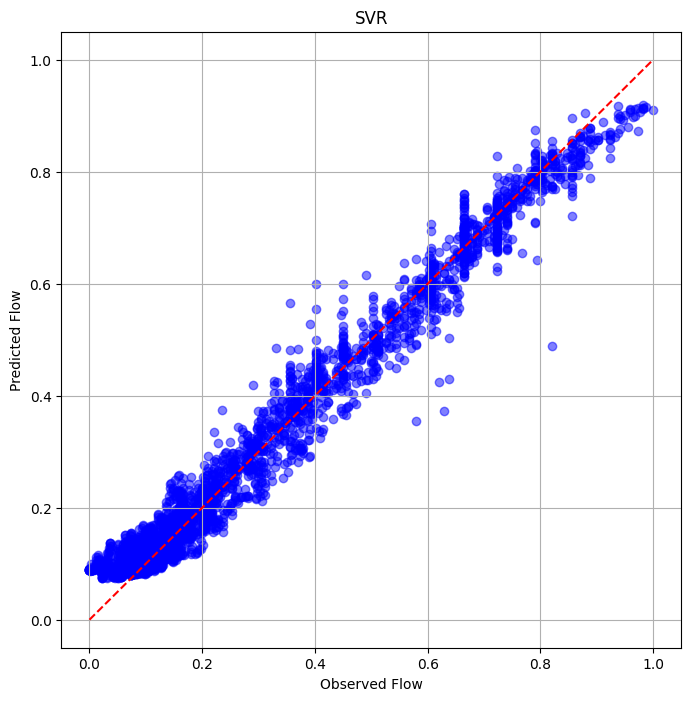

In [50]:
import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('SVR')
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow')
plt.grid(True)
plt.show()
